In [1]:
import data, model.unet, model.autoencoder, loss, function
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import torch.utils.tensorboard as tb
import torchvision

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
tb_writer = tb.SummaryWriter('log')

In [3]:
VAL_PORTION = 0.1
ITERATIONS = 15002
VAL_ITERATIONS = 5
RESOLUTION = 64
CHANNELS = 3
STYLE_DIM = 512
BATCH_SIZE = 8
LOSS_TYPE = 'l1'

CONTENT_LOSS_WEIGHTS = {
    #'relu_1_1' : 1e-2,
    #'relu_4_2' : 5e-3,
    'relu_4_2' : 5e-1,
    'relu_5_2' : 5e-1,
}

STYLE_LOSS_WEIGHTS = {
    'relu_1_2' : 1e2,
    'relu_2_2' : 1e2,
    'relu_3_2' : 5e2,
    'relu_4_2' : 1e1,
    'relu_5_2' : 1e1,
}

data_style = data.load_debug_dataset('../dataset/debug/style', resolution=RESOLUTION)
data_content = data.load_debug_dataset('../dataset/debug/content', resolution=RESOLUTION)

In [4]:
data_style = data.load_dataset('../dataset/style', resolution=RESOLUTION)
data_content = data.load_dataset('../dataset/content', resolution=RESOLUTION)

In [5]:
data_content_train, data_content_val = torch.utils.data.random_split(data_content, [len(data_content) - int(VAL_PORTION * len(data_content)), int(VAL_PORTION * len(data_content))])
data_style_train, data_style_val = torch.utils.data.random_split(data_style, [len(data_style) - int(VAL_PORTION * len(data_style)), int(VAL_PORTION * len(data_style))])
data_loader_content_train = DataLoader(data_content_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_content_val = DataLoader(data_content_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_style_train = DataLoader(data_style_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_style_val = DataLoader(data_style_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_train = data.DatasetPairIterator(data_loader_content_train, data_loader_style_train)
data_loader_val = data.DatasetPairIterator(data_loader_content_val, data_loader_style_val)

In [6]:
CONTENT_DOWN_CONVOLUTIONS = 3
STYLE_DOWN_CONVOLUTIONS = 5

normalization = ['adain', 'adain', 'adain', 'adain', 'adain']
unet = model.unet.UNetAutoencoder(3, STYLE_DIM, residual_downsampling=True, residual_adain=True, residual_upsampling=True, 
        down_normalization='in', up_normalization='adain', num_adain_convolutions=4, 
        num_downup_convolutions=CONTENT_DOWN_CONVOLUTIONS, output_activation='sigmoid')
style_encoder = model.autoencoder.Encoder(STYLE_DIM, num_down_convolutions=CONTENT_DOWN_CONVOLUTIONS)


loss_net = loss.LossNet()
_ = loss_net.eval()

In [7]:
if torch.cuda.is_available(): 
    unet = unet.cuda()
    style_encoder = style_encoder.cuda()
    loss_net = loss_net.cuda()

trainable_parameters = []
for parameter in unet.parameters():
    trainable_parameters.append(parameter)
for parameter in style_encoder.parameters():
    trainable_parameters.append(parameter)

In [ ]:
optimizer = torch.optim.Adam(trainable_parameters, lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True, min_lr=1e-6)

    0 / 15002: loss : 9.4707 -- perceptual loss : 1.7395 -- style loss : 7.7313
Validation...


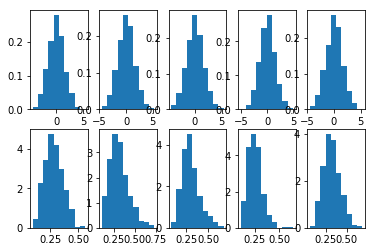


Average val loss: 9.757889747619629
Training with lr 0.0001...
  100 / 15002: loss : 7.1027 -- perceptual loss : 1.3937 -- style loss : 5.709072
Validation...


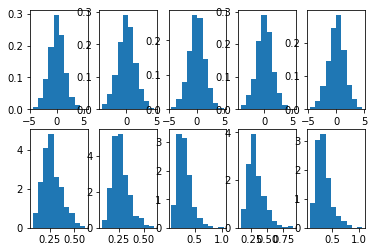


Average val loss: 7.831155300140381
Training with lr 0.0001...
  200 / 15002: loss : 7.3809 -- perceptual loss : 1.3100 -- style loss : 6.070813
Validation...


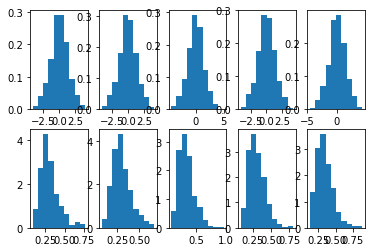


Average val loss: 7.798157691955566
Training with lr 0.0001...
  300 / 15002: loss : 6.6491 -- perceptual loss : 1.2924 -- style loss : 5.356730
Validation...


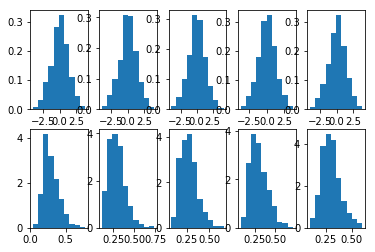


Average val loss: 7.040313243865967
Training with lr 0.0001...
  400 / 15002: loss : 10.7548 -- perceptual loss : 1.1815 -- style loss : 9.5734
Validation...


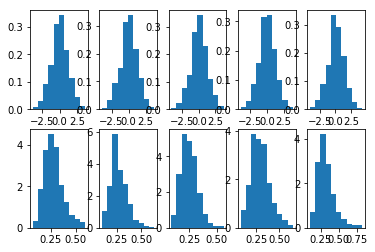


Average val loss: 7.2987823486328125
Training with lr 0.0001...
  500 / 15002: loss : 6.4854 -- perceptual loss : 1.3563 -- style loss : 5.12911
Validation...


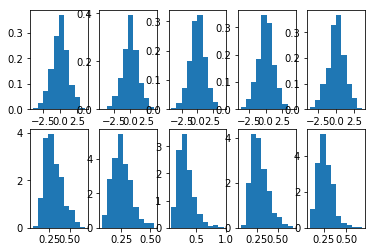


Average val loss: 7.057538032531738
Training with lr 0.0001...
  600 / 15002: loss : 6.7939 -- perceptual loss : 1.1364 -- style loss : 5.6574
Validation...


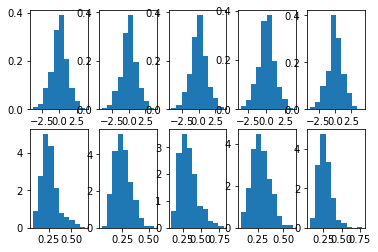


Average val loss: 6.665546417236328
Training with lr 0.0001...
  700 / 15002: loss : 6.0089 -- perceptual loss : 1.2931 -- style loss : 4.71589
Validation...


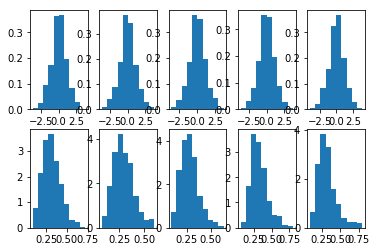


Average val loss: 6.780374050140381
Training with lr 0.0001...
  800 / 15002: loss : 7.0704 -- perceptual loss : 1.2562 -- style loss : 5.81423
Validation...


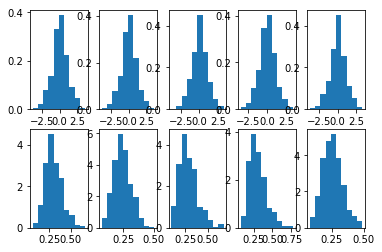


Average val loss: 6.446427822113037
Training with lr 0.0001...
  900 / 15002: loss : 6.2700 -- perceptual loss : 1.2910 -- style loss : 4.9790
Validation...


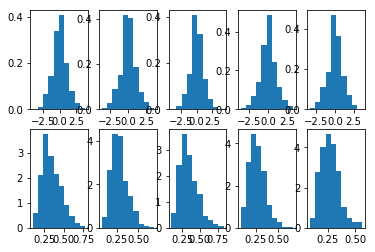


Average val loss: 6.509973049163818
Training with lr 0.0001...
 1000 / 15002: loss : 8.5687 -- perceptual loss : 1.2823 -- style loss : 7.28639
Validation...


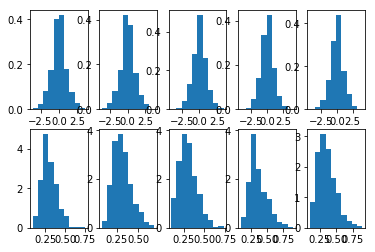


Average val loss: 7.530245304107666
Training with lr 0.0001...
 1100 / 15002: loss : 6.5971 -- perceptual loss : 1.4359 -- style loss : 5.16122
Validation...


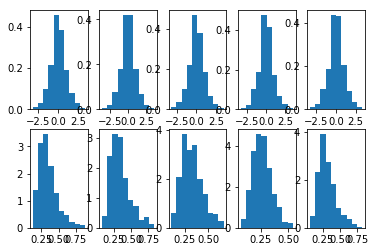


Average val loss: 6.250622749328613
Training with lr 0.0001...
 1200 / 15002: loss : 4.6350 -- perceptual loss : 1.2810 -- style loss : 3.35404
Validation...


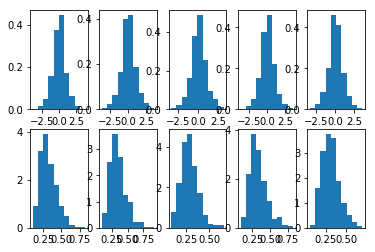


Average val loss: 7.213405132293701
Training with lr 0.0001...
 1300 / 15002: loss : 6.6331 -- perceptual loss : 1.4463 -- style loss : 5.1868
Validation...


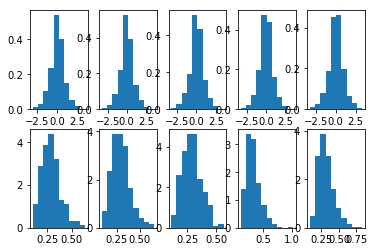


Average val loss: 5.70815896987915
Training with lr 0.0001...
 1400 / 15002: loss : 5.7019 -- perceptual loss : 1.2076 -- style loss : 4.4943
Validation...


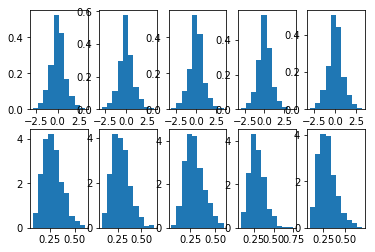


Average val loss: 6.198793888092041
Training with lr 0.0001...
 1500 / 15002: loss : 6.5067 -- perceptual loss : 1.3096 -- style loss : 5.1971
Validation...


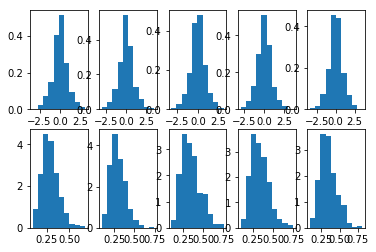


Average val loss: 6.931451320648193
Training with lr 0.0001...


In [ ]:
iteration = 0
val_step = 0
for (content_image, content_path), (style_image, style_path) in data_loader_train:
    if iteration >= ITERATIONS: 
        break
    if torch.cuda.is_available():
        content_image = content_image.to('cuda')
        style_image = style_image.to('cuda')
    
    unet.train(), style_encoder.train()
    optimizer.zero_grad()
    
    style_encoding = style_encoder(style_image)
    stylized = unet(content_image, style_encoding)
    
    features_content = loss_net(content_image)
    features_style = loss_net(style_image)
    features_stylized = loss_net(stylized)
    
    perceptual_loss = loss.perceptual_loss(features_content, features_stylized, CONTENT_LOSS_WEIGHTS, loss=LOSS_TYPE)
    style_loss = loss.style_loss(features_style, features_stylized, STYLE_LOSS_WEIGHTS, loss=LOSS_TYPE)
    total_loss = perceptual_loss + style_loss
    total_loss.backward()
    optimizer.step()
    
    tb_writer.add_scalar('train loss', total_loss.item(), iteration)
    tb_writer.add_scalar('train perceptual loss', perceptual_loss.item(), iteration)
    tb_writer.add_scalar('train style loss', style_loss.item(), iteration)
    print(f'\r{iteration:5d} / {ITERATIONS}: loss : {total_loss.item():.4f} -- perceptual loss : {perceptual_loss.item():.4f} -- style loss : {style_loss.item():.4f}', end='\r')
    
    if iteration % 100 == 0:
        #tb_writer.add_images('train images', torch.from_numpy(np.concatenate([
        #    data.vgg_normalization_undo(img.detach().cpu().numpy()) for img in [content_image, style_image, stylized]
        #])), iteration)
        # Validate
        print('\nValidation...')
        total_val_loss = 0.0
        with torch.no_grad():
            val_iteration = 0
            unet.eval(), style_encoder.eval()
            fig = plt.figure()
            for (content_image, content_path), (style_image, style_path) in data_loader_val:
                
                if val_iteration >= VAL_ITERATIONS:
                    break
                    
                if torch.cuda.is_available():
                    content_image = content_image.to('cuda')
                    style_image = style_image.to('cuda')
                
                style_encoding = style_encoder(style_image)
                stylized = unet(content_image, style_encoding)
                
                torch.set_printoptions(profile="full")
                #print(content_encoding)
                torch.set_printoptions(profile="default")
    
                features_content = loss_net(content_image)
                features_style = loss_net(style_image)
                features_stylized = loss_net(stylized)

                perceptual_loss = loss.perceptual_loss(features_content, features_stylized, CONTENT_LOSS_WEIGHTS, loss=LOSS_TYPE)
                style_loss = loss.style_loss(features_style, features_stylized, STYLE_LOSS_WEIGHTS, loss=LOSS_TYPE)
                total_loss = perceptual_loss + style_loss
                total_val_loss += total_loss
                fig.add_subplot(2, VAL_ITERATIONS, val_iteration + 1)
                plt.hist(style_encoding.detach().cpu().numpy().reshape(-1), density=True)
                fig.add_subplot(2, VAL_ITERATIONS, VAL_ITERATIONS + val_iteration + 1)
                plt.hist(style_encoding.detach().cpu().numpy().std(0), density=True)
                
                tb_writer.add_scalar('validation loss', total_loss.item(), val_step)
                tb_writer.add_scalar('validation perceptual loss', perceptual_loss.item(), val_step)
                tb_writer.add_scalar('validation style loss', style_loss.item(), val_step)
                tb_writer.add_images('validation images', torch.from_numpy(np.concatenate([
                    img.detach().cpu().numpy() for img in [content_image, style_image, stylized]
                ])), val_step)
                val_iteration += 1
                val_step += 1
                print(f'\r{val_iteration:5d} / {VAL_ITERATIONS}: loss : {total_loss.item():.4f} -- perceptual loss : {perceptual_loss.item():.4f} -- style loss : {style_loss.item():.4f}', end='\r')
            
            plt.show()
            total_val_loss /= VAL_ITERATIONS
            print(f'\nAverage val loss: {total_val_loss}')
            lr_scheduler.step(total_val_loss)
            print(f'Training with lr {optimizer.param_groups[0]["lr"]}...')
            
            
    iteration += 1
    
    

# Old Training Loop

In [ ]:


optimizer = torch.optim.Adam(trainable_parameters, lr=1e-6)


iteration = 0
running_perceptual_loss, running_style_loss, running_count = 0.0, 0.0, 0

content_loss_history_train = []
style_loss_history_train = []
content_loss_history_val = []
style_loss_history_val = []

for (content_image, content_path), (style_image, style_path) in data_loader_train:
    if iteration >= ITERATIONS: break
    iteration += 1
    
    content_encoder.train()
    style_encoder.train()
    decoder.train()

    optimizer.zero_grad()
    if torch.cuda.is_available():
        content_image = content_image.to('cuda')
        style_image = style_image.to('cuda')

    #content_representation = content_encoder(content_image)
    #style_representation = style_encoder(style_image)

    #transformed_content = function.adain(content_representation, style_representation)
    #transformed = decoder(transformed_content)
    #transformed = decoder(content_representation, style_representation)
    
    transformed, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

    features_content = loss_net(content_image)
    features_style = loss_net(style_image)
    features_transformed = loss_net(transformed)

    perceptual_loss = loss.perceptual_loss(features_content, features_transformed, CONTENT_LOSS_WEIGHTS)
    style_loss = loss.style_loss(features_style, features_transformed, STYLE_LOSS_WEIGHTS)
    
    lambda_content = 1.0
    lambda_style = 1.0

    total_loss = lambda_content * perceptual_loss + lambda_style * style_loss

    total_loss.backward()
    optimizer.step()

    running_perceptual_loss += perceptual_loss.item()
    running_style_loss += style_loss.item()

    running_count += 1

    print(f'\r{iteration:06d} : avg perceptual_loss : {running_perceptual_loss / running_count:.4f}\tavg style loss : {running_style_loss / running_count:.4f}', end='\r')
    content_loss_history_train.append(perceptual_loss.item())
    style_loss_history_train.append(style_loss.item())
    
    if iteration % 5000 == 1:
        torch.save(content_encoder.state_dict(), f'output/content_encoder_{iteration}')
        torch.save(style_encoder.state_dict(), f'output/style_encoder_{iteration}')
        torch.save(decoder.state_dict(), f'output/decoder_{iteration}')

    if iteration % 500 == 1:

        running_perceptual_loss, running_style_loss, running_count = 0.0, 0.0, 0 # After each validation, reset running training losses
        print(f'\nValidating...')

        content_encoder.eval()
        style_encoder.eval()
        decoder.eval()
        perceptual_loss = 0.0
        style_loss = 0.0
        val_iteration = 0

        with torch.no_grad():

            torch.save(content_image.cpu(), f'output/{iteration}_0_content.pt')
            torch.save(style_image.cpu(), f'output/{iteration}_0_style.pt')
            #torch.save(decoder(style_representation).cpu(), f'output/{iteration}_0_style_reconstructed.pt')
            #torch.save(decoder(content_representation).cpu(), f'output/{iteration}_0_reconstructed.pt')
            torch.save(transformed.cpu(), f'output/{iteration}_0_transformed.pt')


            for (content_image, content_path), (style_image, style_path) in data_loader_val:
                val_iteration += 1
                if val_iteration > VAL_ITERATIONS: break

                if torch.cuda.is_available():
                    content_image = content_image.to('cuda')
                    style_image = style_image.to('cuda')

                #content_representation = content_encoder(content_image)
                #style_representation = style_encoder(style_image)

                #transformed_content = function.adain(content_representation, style_representation)
                #reconstruction = decoder(transformed_content)
                #reconstruction = decoder(content_representation, style_representation)
                
                reconstruction, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

                features_content = loss_net(content_image)
                features_style = loss_net(style_image)
                features_reconstruction = loss_net(reconstruction)
                
                print("------------------------------------------------------------------")
                print("Features content:")
                print_content_feature_contrib(features_content, features_reconstruction)
                print("Features style:")
                print_style_feature_contrib(features_style, features_reconstruction)
                print("------------------------------------------------------------------")
                
                perceptual_loss += loss.perceptual_loss(features_content, features_reconstruction, CONTENT_LOSS_WEIGHTS)
                style_loss += loss.style_loss(features_style, features_reconstruction, STYLE_LOSS_WEIGHTS)
                    
                torch.save(content_image.cpu(), f'output/{iteration}_{val_iteration}_content.pt')
                torch.save(style_image.cpu(), f'output/{iteration}_{val_iteration}_style.pt')
                torch.save(reconstruction.cpu(), f'output/{iteration}_{val_iteration}_reconstruction.pt')
                #torch.save(decoder(style_representation).cpu(), f'output/{iteration}_{val_iteration}_style_reconstruction.pt')

                print(f'\rValidation {val_iteration:02d} : Perceptual loss {perceptual_loss / val_iteration:.4f}\tStyle loss {style_loss / val_iteration:.4f}', end='\r')
            print('\nValidation done.')
            val_iteration -= 1
            content_loss_history_val.append((iteration, perceptual_loss / val_iteration))
            style_loss_history_val.append((iteration, style_loss / val_iteration))

            torch.save(content_loss_history_train, 'output/content_loss_history_train.pt')
            torch.save(style_loss_history_train, 'output/style_loss_history_train.pt')
            torch.save(content_loss_history_val, 'output/content_loss_history_val.pt')
            torch.save(style_loss_history_val, 'output/style_loss_history_val.pt')
            

In [ ]:
def forward(content, style, content_encoder, style_encoder, decoder):
    """ Forwards a batch through the pipeline.
    
    Parameters:
    -----------
    content : torch.Tensor, shape [B, C, H, W]
        The content image.
    style : torch.Tensor, shape [B, C, H', W']
        The style image, usually H' = H and W' = W.
    content_encoder : torch.nn.modules.Module
        Encoder for content images.
    style_encoder : torch.nn.modules.Module
        Encoder for style images.
    decoder : torch.nn.modules.Module
        Decoder that uses AdaIn to decode the content and apply the style.

    Returns:
    --------
    reco : torch.Tensor, shape [B, C, H, W]
        A reconstruction of the content after application of the style.
    content_representation : torch.Tensor, shape [B, D]
        Content representation.
    style_representation : torch.Tensor, shape [B, D']
        The latent style representation.
    """
    content_representation = content_encoder(content)
    style_representation = style_encoder(style)
    #transformed_content = function.adain(content_representation, style_representation)
    #print(content_representation.shape)
    #print(style_representation.shape)
    reco = decoder(content_representation, style_representation)
    #reco = decoder(content_representation)
    return reco, content_representation, style_representation

def print_content_feature_contrib(feature_activations_x, feature_activations_y):
    for key in feature_activations_x:
        feature_loss = torch.nn.functional.mse_loss(feature_activations_x[key], feature_activations_y[key])
        weight = 0.0
        if key in CONTENT_LOSS_WEIGHTS:
            weight = CONTENT_LOSS_WEIGHTS[key]
        weighted_loss = weight * feature_loss
        print("Content layer {} loss: {} weight: {} weighted loss: {}".format(key, feature_loss, weight, weighted_loss))

def print_style_feature_contrib(features_style, features_transformed):
    for key, weight in STYLE_LOSS_WEIGHTS.items():
        Gx = function.gram_matrix(features_style[key])
        Gy = function.gram_matrix(features_transformed[key])
        value = torch.nn.functional.mse_loss(Gx, Gy)
        weighted_value = weight * value
        print(f'Style loss {key} with weight {weight}: {value} weighted loss: {weighted_value}')

# Evaluate

In [ ]:
CONTENT_LOSS_WEIGHTS = {
    'relu_4_2' : 5e-2,
}

STYLE_LOSS_WEIGHTS = {
    'relu_1_1' : 1e3,
    'relu_2_1' : 1e3,
    'relu_3_1' : 1e3,
    'relu_4_1' : 1e3,
    'relu_5_1' : 1e3,
}
RESOLUTION = 256
ITERATION = 5001
EVAL_ITERATIONS = 1
BATCH_SIZE = 1

data_style = data.load_debug_dataset('../dataset/debug/style', resolution=RESOLUTION)
data_loader_style_eval = DataLoader(data_style, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

data_content = data.load_debug_dataset('../dataset/debug/content', resolution=RESOLUTION)
data_loader_content_eval = DataLoader(data_content, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

data_loader_eval = data.DatasetPairIterator(data_loader_content_eval, data_loader_style_eval)

content_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True, flattened_output_dim=STYLE_DIM)
style_encoder = model.Encoder((3, RESOLUTION, RESOLUTION), pretrained=True)
#decoder = model.Decoder(STYLE_DIM)
decoder = model.Decoder()

content_encoder.load_state_dict(torch.load(f'output_train_places365_starry_night/content_encoder_{ITERATION}'))
style_encoder.load_state_dict(torch.load(f'output_train_places365_starry_night/style_encoder_{ITERATION}'))
decoder.load_state_dict(torch.load(f'output_train_places365_starry_night/decoder_{ITERATION}'))

loss_net = loss.LossNet()
loss_net.eval()

# Networks to CUDA device
if torch.cuda.is_available(): 
    content_encoder = content_encoder.cuda()
    style_encoder = style_encoder.cuda()
    decoder = decoder.cuda()
    loss_net = loss_net.cuda()

content_encoder.eval()
style_encoder.eval()
decoder.eval()

with torch.no_grad():
    eval_iteration = 0

    for (content_image, content_path), (style_image, style_path) in data_loader_eval:
        if eval_iteration >= EVAL_ITERATIONS:
            break

        perceptual_loss = 0.0
        style_loss = 0.0
        eval_iteration += 1

        if torch.cuda.is_available():
            content_image = content_image.to('cuda')
            style_image = style_image.to('cuda')

        #content_representation = content_encoder(content_image)
        #style_representation = style_encoder(style_image)

        #transformed_content = function.adain(content_representation, style_representation)
        #reconstruction = decoder(transformed_content)
        #reconstruction = decoder(content_representation, style_representation)

        reconstruction, style_representation = forward(content_image, style_image, content_encoder, style_encoder, decoder)

        features_content = loss_net(content_image)
        features_style = loss_net(style_image)
        features_reconstruction = loss_net(reconstruction)

        perceptual_loss += loss.perceptual_loss(features_content, features_reconstruction, CONTENT_LOSS_WEIGHTS)
        style_loss += loss.style_loss(features_style, features_reconstruction, STYLE_LOSS_WEIGHTS)

        torch.save(content_image.cpu(), f'output/eval_{eval_iteration}_content.pt')
        torch.save(style_image.cpu(), f'output/eval_{eval_iteration}_style.pt')
        torch.save(reconstruction.cpu(), f'output/eval_{eval_iteration}_reconstruction.pt')

        print(f'Evaluation {eval_iteration:02d} : Perceptual loss {perceptual_loss:.4f}\tStyle loss {style_loss:.4f}')


# Other

In [ ]:
plt.plot(content_loss_history_train[10:], "r")
plt.plot(style_loss_history_train[10:], "b")
plt.plot(*zip(*content_loss_history_val), "r--")
plt.plot(*zip(*style_loss_history_val), "b--")

In [ ]:
image_batch = torch.load("./output/91_9_reconstruction.pt")
image_batch = data.vgg_normalization_undo(image_batch.numpy())
#plt.imshow(transforms.ToPILImage()(image))
image_batch = np.transpose(image_batch, (0, 2, 3, 1))
plt.imshow(image_batch[0])

In [ ]:
def show_images(epoch, iteration):
    content_batch = torch.load("./output/{}_{}_content.pt".format(epoch, iteration))
    style_batch = torch.load("./output/{}_{}_style.pt".format(epoch, iteration))
    reconstruction_batch = torch.load("./output/{}_{}_reconstruction.pt".format(epoch, iteration))
    
    content_batch = data.vgg_normalization_undo(content_batch.numpy())
    style_batch = data.vgg_normalization_undo(style_batch.numpy())
    reconstruction_batch = data.vgg_normalization_undo(reconstruction_batch.numpy())
    
    content_batch = np.transpose(content_batch, (0, 2, 3, 1))
    style_batch = np.transpose(style_batch, (0, 2, 3, 1))
    reconstruction_batch = np.transpose(reconstruction_batch, (0, 2, 3, 1))
    
    fig = plt.figure(figsize=(12, 4))
    
    fig.add_subplot(1, 3, 1)
    plt.imshow(content_batch[0])
    
    fig.add_subplot(1, 3, 2)
    plt.imshow(style_batch[0])
    
    fig.add_subplot(1, 3, 3)
    plt.imshow(reconstruction_batch[0])

In [ ]:
show_images(1, 1)

In [ ]:
print(STYLE_DIM)

In [ ]:
np.arange(0, 1.05, 0.05)

In [ ]:
data.resize_images_offline("../dataset/style", "../dataset/style_resized")

In [ ]:
data.resize_images_offline("../dataset/debug/style", "../dataset/debug/style_resized")